# Data Cleaning, Handle missing value for all data after Union, Join and some basic step in table prep 

## 1. Import necessary libraries and files

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns

In [2]:
%cd ..

d:\OneDrive - Hanoi University of Science and Technology\HUST\CLASS\20211\DataScience\Project\Test_alonhadat


In [3]:
estate_df_origin = pd.read_csv('resources/data/final/out_tableau/official.csv', low_memory=False)
estate_df = estate_df_origin

## 2. Summary of data

In [4]:
estate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68117 entries, 0 to 68116
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   district            68117 non-null  object 
 1   price_per_square    68117 non-null  float64
 2   address             68117 non-null  object 
 3   furniture           18248 non-null  object 
 4   floornumber         1230 non-null   float64
 5   area                68117 non-null  float64
 6   direction           16836 non-null  object 
 7   price               68117 non-null  float64
 8   lat                 68117 non-null  float64
 9   lng                 68117 non-null  float64
 10  bedroom             58513 non-null  float64
 11  bathroom            44387 non-null  float64
 12  floors              45608 non-null  float64
 13  house_type          68117 non-null  object 
 14  facade              19051 non-null  float64
 15  street_size         18462 non-null  float64
 16  dist

## 3. Process

Drop some redundant collumns

In [5]:

estate_df = estate_df.drop('district-1', 1)
estate_df = estate_df.drop('city', 1)

types_dict = {
    'floornumber': pd.Int64Dtype(),
    'bedroom': pd.Int64Dtype(),
    'bathroom': pd.Int64Dtype(),
    'floors': pd.Int64Dtype()
}

for col, col_type in types_dict.items():
    estate_df[col] = estate_df[col].astype(col_type)

C:\Users\khong\AppData\Local\Temp/ipykernel_9628/3631682377.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  estate_df = estate_df.drop('district-1', 1)
C:\Users\khong\AppData\Local\Temp/ipykernel_9628/3631682377.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  estate_df = estate_df.drop('city', 1)


Number of null in each column

In [6]:
estate_df.isnull().sum()

district                  0
price_per_square          0
address                   0
furniture             49869
floornumber           66887
area                      0
direction             51281
price                     0
lat                       0
lng                       0
bedroom                9604
bathroom              23730
floors                22509
house_type                0
facade                49066
street_size           49655
num_people                0
area(m2)                  0
density(people/m2)        0
note                      0
dtype: int64

In [7]:
estate_df.sample()

,district,price_per_square,address,furniture,floornumber,area,direction,price,lat,lng,bedroom,bathroom,floors,house_type,facade,street_size,num_people,area(m2),density(people/m2),note
15022,Long Biên,31.75,"Đường Huỳnh Văn Nghệ, Phường Sài Đồng, Long Bi...",Hoàn thiện cơ bản,<NA>,63.0,Tây,2.0,21.03445,105.91374,2,2,1,Căn hộ chung cư,NaN,NaN,322549,59.8,5394,quận


# Set interval for some fields

We decide to set the interval:

    price : 0 -> 300 (billion  vnd)

    area : 0 -> 500 (meter square)
    
    price / m2 : 0-> 3000 (million per meter square)


In [8]:
max_price = 300
max_area = 500
max_price_m2 = 3000

## Outlier Detect

Because the data is skew, we decide to use IQR score to detect outliers

In [9]:
def filter_and_boxplot(df, field ,lower, upper):
    df = df.loc[(df[field] <= upper) & (df[field] >= lower)]
    sns.boxplot(x = df[field])
    return df

def find_lower_upper(df,field):
    quantile1, quantile3 = np.percentile(estate_df[field], [25,75])
    iqr_value=quantile3 - quantile1
    lower_bound = max(quantile1 - (1.5 * iqr_value),0)
    upper_bound = quantile3 + (1.5 * iqr_value)
    print('====== ', field , ' =======')
    print('Lower bound: ', lower_bound)
    print('Upper bound: ', upper_bound)
    return lower_bound, upper_bound

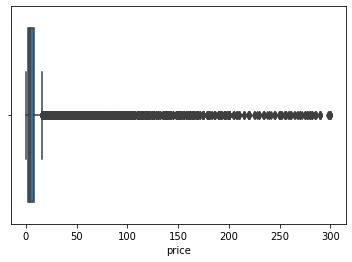

In [10]:
estate_df = filter_and_boxplot(estate_df, 'price', 0,max_price )

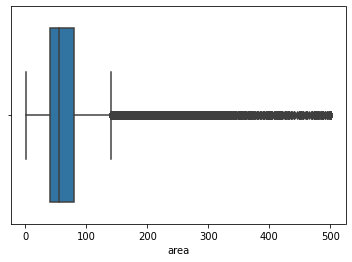

In [11]:
estate_df = filter_and_boxplot(estate_df, 'area', 0,max_area )

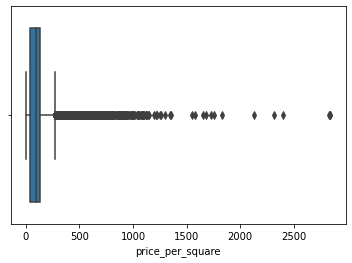

In [12]:
estate_df = filter_and_boxplot(estate_df, 'price_per_square', 0,max_price_m2 )

In [13]:
estate_df.house_type.unique()

array(['Nhà trong hẻm', 'Nhà mặt tiền', 'Nhà ở-Nhà biệt thự',
       'Bán loại bất động sản khác', 'Căn hộ chung cư', 'Bán đất'],
      dtype=object)

Sẽ xoá outlier tương ứng với mỗi quận huyện và loại nhà

In [14]:
def remove_outliers(df, field):
    df_out = pd.DataFrame()
    print('========', field, '======')
    index_list = []
    min_field = 100000
    max_field = 0
    
    for key, subdf in df.groupby(['district','house_type']):
        Q1 = subdf[field].quantile(0.25)
        Q3 = subdf[field].quantile(0.75)
        IQR = Q3 - Q1
        low = max(Q1 - 1.5 * IQR, 0)
        up = Q3 + 1.5 * IQR
        ls = subdf.index[(subdf[field] < low) | (subdf[field] > up)]
        # print(key, end=': ')
        # print('Get value from ', f'{low:.2f}', ' to ', f'{up:.2f}')
        index_list.extend(ls)
        min_field = min(min_field, low)
        max_field = max(max_field, up)
        
    print(field, ': ', f'{min_field:.2f}', ' to ', f'{max_field:.2f}')
    return index_list

In [15]:
def remove(df, index_list):
    index_list = sorted(set(index_list))
    df_out = df.drop(index_list)
    return df_out

In [16]:
index_list = []
for feature in ['price', 'area', 'price_per_square']:
    index_list.extend(remove_outliers(estate_df, feature))

======== price ======
price :  0.00  to  380.00
======== area ======
area :  0.00  to  922.00
======== price_per_square ======
price_per_square :  0.00  to  1194.18


We can see after all:

    *Price : 0 to 389 
    
    *Area : 0 to 922

    *Price per square: 0 to 1194


It's reasonable and consistent with the general knowledge about real estate market we have

In [17]:
len(set(index_list))

7717

In [18]:
df_cleaned = remove(estate_df, index_list)

# Fill missing values

In [19]:
len_df = len(df_cleaned)
print("Number of records: ", len_df)

print("Percent of missing values: ")
df_cleaned.isnull().sum() / len_df * 100 

Number of records:  59591
Percent of missing values: 


district               0.000000
price_per_square       0.000000
address                0.000000
furniture             71.968921
floornumber           98.219530
area                   0.000000
direction             74.744508
price                  0.000000
lat                    0.000000
lng                    0.000000
bedroom               12.100821
bathroom              32.375694
floors                33.090567
house_type             0.000000
facade                74.254502
street_size           74.615294
num_people             0.000000
area(m2)               0.000000
density(people/m2)     0.000000
note                   0.000000
dtype: float64

With bedroom bathroom, floors the percentage of missing data is acceptable -> fill with median of each group
floornumber is only relate to department, only batdongsan website have this field so we decide to leave it as it is
furniture we decide to drop
facade và street_size : we analysis non null records, try to get some results

In [20]:
def fill_missing(df, field):
    df_out = pd.DataFrame()
    print('========', field, '======')
    for key, subdf in df.groupby(['district','house_type']):
        med = subdf[field].median()
        if not pd.isna(med):
            med = int(med)
        subdf[field] = subdf[field].fillna(med)
        print(key, end=': ')
        print('Fill missing ', field , ' with ', med)
        df_out = pd.concat([df_out, subdf], ignore_index=True)
    return df_out

In [ ]:
df_cleaned = fill_missing(df_cleaned,'bedroom')
df_cleaned = fill_missing(df_cleaned, 'bathroom')
df_cleaned = fill_missing(df_cleaned, 'floors')

In [22]:
print("Len: ", len(df_cleaned))
df_cleaned.isna().sum()

Len:  59591


district                  0
price_per_square          0
address                   0
furniture             42887
floornumber           58530
area                      0
direction             44541
price                     0
lat                       0
lng                       0
bedroom                 754
bathroom               1089
floors                  506
house_type                0
facade                44249
street_size           44464
num_people                0
area(m2)                  0
density(people/m2)        0
note                      0
dtype: int64

After all we have 59591 records

In [23]:
df_cleaned.to_csv('resources/data/final/out_tableau/official_done_process.csv', index=False)